# 1. import library and read data

In [1]:
import sys
import os
import rospy
import rospkg
import cv2
import numpy as np

# import python module of depth_segmentation
lib_path = "/home/yang/thesis_test/toolbox/voxbloxpp_ws/devel/lib"
sys.path.append(lib_path)
import depth_segmentation_py

In [16]:
# read images
import rospy
from cv_bridge import CvBridge
import rosbag
from scipy.spatial.transform import Rotation as R

rosbag_file = "/media/yang/linux2/thesis_test/data/scenenn_231/scenenn_231.bag"
rgb_topic = "/camera/rgb/image_raw"
depth_topic = "/camera/depth/image_raw"
rgb_cam_info_topic = "/camera/rgb/camera_info"
depth_cam_info_topic = "/camera/depth/camera_info"
tf_topic = "/tf"

bridge = CvBridge()
bag = rosbag.Bag(rosbag_file, 'r')

depth_msg_list = []
rgb_msg_list = []

depth_image_list = []
rgb_image_list = []
pose_list = []
tf_list = []
depth_cam_info = None

for topic, msg, t in bag.read_messages(topics = [depth_topic,depth_cam_info_topic,rgb_topic,tf_topic]):
    if topic == depth_cam_info_topic:
        if depth_cam_info is None:
            depth_cam_info = msg
        
    elif topic == depth_topic:
        depth_img = bridge.imgmsg_to_cv2(msg)
        depth_image_list.append(depth_img)
        depth_msg_list.append(msg)

    elif topic == rgb_topic:
        rgb_img = bridge.imgmsg_to_cv2(msg)
        rgb_image_list.append(rgb_img)
        rgb_msg_list.append(msg)

    elif topic == tf_topic:
        tf_list.append(msg)
        translation = msg.transforms[0].transform.translation
        quat = msg.transforms[0].transform.rotation
        r = R.from_quat([quat.x, quat.y, quat.z,quat.w])
        rotation = r.as_dcm()
        T_G_C = np.eye(4).astype(float)
        T_G_C[:3,:3] = rotation
        T_G_C[:3,3] = [translation.x,translation.y,translation.z]
        pose_list.append(T_G_C)


In [17]:
tf_list[0]

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:  33515999
      frame_id: "/world"
    child_frame_id: "/scenenn_camera_frame"
    transform: 
      translation: 
        x: -1.99841
        y: 0.985952
        z: 0.23172
      rotation: 
        x: -0.437562680711
        y: -0.14212981639
        z: 0.887839831843
        w: -0.00885712905714

# 2. Depth segmentation and geometric confidence

In [9]:
def preprocess(depth_img):
    depth_img_rescaled = None
    if depth_img.dtype == np.uint16:
        # convert depth image from mili-meters to meters
        depth_img_rescaled = cv2.rgbd.rescaleDepth(depth_img, cv2.CV_32FC1)
    elif depth_img.dtype == np.float:
        depth_img_rescaled = depth_img
    else:
        print("Unknown depth image encoding.")
        return None

    kZeroValue = 0.0
    nan_mask = (depth_img_rescaled != depth_img_rescaled)
    depth_img_rescaled[nan_mask] = kZeroValue # set nan pixels to 0

    return depth_img_rescaled

def show_images(images_list, mode = 'column', cmap = None, size = (5,4)):
    if(len(images_list)>10):
        print(" too much images!")
        return None

    num_images = len(images_list)
    import matplotlib.pyplot as plt
    plt.figure(figsize=size)
    # fig.set_figheight(15)
    # fig.set_figwidth(15)
    if mode == 'column':
        for index,image in enumerate(images_list):
            plt.subplot(num_images,1,index+1)
            plt.imshow(image, cmap)
    elif mode == 'row':
        for index,image in enumerate(images_list):
            plt.subplot(1,num_images,index+1)
            plt.imshow(image, cmap)

In [27]:
height = depth_image_list[0].shape[0]
width = depth_image_list[0].shape[1]
K_depth = np.array(depth_cam_info.K).reshape(3,3)
segmentor = depth_segmentation_py.DepthSegmentation_py(height,width,cv2.CV_32FC1, K_depth)
img_index = 5000

depth_img = depth_image_list[img_index]
rgb_img = rgb_image_list[img_index]
pose = pose_list[img_index]

depth_img_scaled = preprocess(depth_img)
segmentor.depthSegment(depth_img_scaled,rgb_img.astype(np.float))

depth_map = segmentor.get_depthMap()
normal_map = segmentor.get_normalMap()
discontinuity_map = segmentor.get_discontinuityMap()
distance_map = segmentor.get_maxDistanceMap()
convexity_map = segmentor.get_minConvexMap()
edge_map = segmentor.get_edgeMap()
label_map = segmentor.get_labelMap()


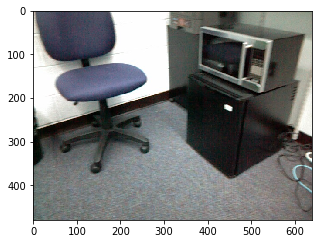

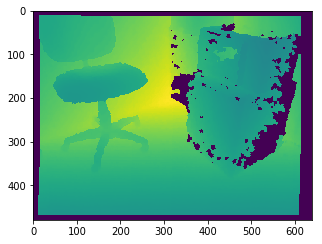

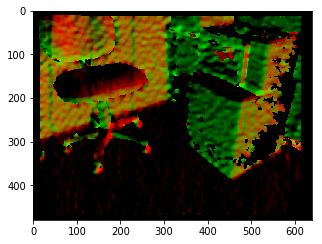

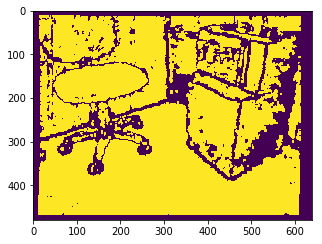

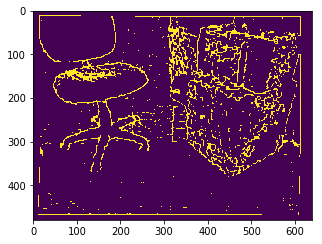

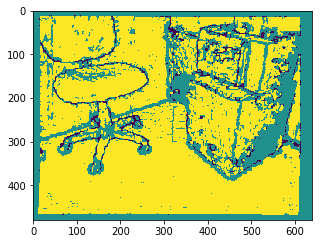

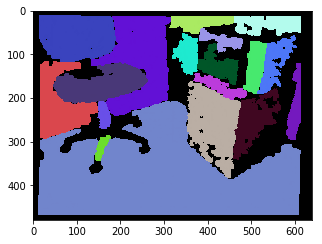

In [28]:
show_images_list = [rgb_img ,depth_img_scaled, normal_map, convexity_map, discontinuity_map, edge_map, label_map]
for show_img in show_images_list:
    show_images([show_img])

In [ ]:
# folder = "/home/yang/thesis_test/meeting/meeting2/images/"
# rgb_folder = folder + "rgb_images/"
# angle_map_folder = folder + "normal_confidence/"
# depth_confidence_folder = folder + "depth_confidence/"
# angle_map_list = []
# depth_confidence_map_list = []
# step = 30
# for index in range(0,min(len(rgb_image_list), len(depth_image_list)), step):
#     angle_map, depth_confidence_map = confidence_calculation(depth_image_list[index],rgb_image_list[index], segmentor)
#     angle_map = np.abs(angle_map)
#     depth_confidence_map = np.abs(depth_confidence_map)

#     max_cos_angle = np.max(angle_map)
#     max_inverse_depth = np.max(depth_confidence_map)
#     angle_map = (255.0*angle_map/max_cos_angle).astype(np.uint8)
#     depth_confidence_map = (255.0*depth_confidence_map/max_inverse_depth).astype(np.uint8)

#     angle_map_list.append(angle_map)
#     depth_confidence_map_list.append(depth_confidence_map)

#     file_name = str(index).zfill(5) + ".png"

#     rgb_f = rgb_folder + file_name
#     depth_confidence_f = depth_confidence_folder + file_name
#     angle_f = angle_map_folder + file_name
#     cv2.imwrite(rgb_f, rgb_image_list[index])
#     cv2.imwrite(depth_confidence_f, depth_confidence_map)
#     cv2.imwrite(angle_f, angle_map)


# 3. semantic segmentation

In [2]:
import sys
from cv_bridge import CvBridge
import matplotlib.pyplot as plt

# load MASK-RCNN related scripts and path

sys.path.append('/home/yang/thesis_test/toolbox/voxbloxpp_ws/src/mask_rcnn_ros/src/mask_rcnn_ros')
sys.path.append('/home/yang/.local/lib/python2.7/site-packages')
sys.path.append('/home/yang/anaconda3/envs/py27/lib/python2.7/plat-linux2')
from mask_rcnn_ros import coco
from mask_rcnn_ros import utils
from mask_rcnn_ros import model as modellib
from mask_rcnn_ros import visualize
from mask_rcnn_ros.msg import Result

ImportError: No module named mask_rcnn_ros

In [1]:
ROS_HOME = os.environ.get('ROS_HOME', os.path.join(os.environ['HOME'], '.ros'))
COCO_MODEL_PATH = os.path.join(ROS_HOME, 'mask_rcnn_coco.h5')

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: CLASS_NAMES.index('teddy bear')
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

class MaskRCNNNode(object):
    def __init__(self):
        config = InferenceConfig()
        config.display()

        # Create model object in inference mode.
        self._model = modellib.MaskRCNN(mode="inference", model_dir="",
                                        config=config)
        # Load weights trained on MS-COCO
        model_path = COCO_MODEL_PATH
        # Download COCO trained weights from Releases if needed
        if model_path == COCO_MODEL_PATH and not os.path.exists(COCO_MODEL_PATH):
            utils.download_trained_weights(COCO_MODEL_PATH)

        self._model.load_weights(model_path, by_name=True)
        self._class_colors = visualize.random_colors(len(CLASS_NAMES))

    def forward(self, np_image):

        # Run detection
        results = self._model.detect([np_image], verbose=0)
        result = results[0]
        return result

    def _visualize(self, result, image):
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        from matplotlib.figure import Figure

        fig = Figure()
        canvas = FigureCanvasAgg(fig)
        axes = fig.gca()
        visualize.display_instances(image, result['rois'], result['masks'],
                                    result['class_ids'], CLASS_NAMES,
                                    result['scores'], ax=axes,
                                    class_colors=self._class_colors)
        fig.tight_layout()
        canvas.draw()
        result = np.fromstring(canvas.tostring_rgb(), dtype='uint8')

        _, _, w, h = fig.bbox.bounds
        result = result.reshape((int(h), int(w), 3))
        return result

NameError: name 'coco' is not defined

In [15]:
node = MaskRCNNNode()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

/home/yang/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


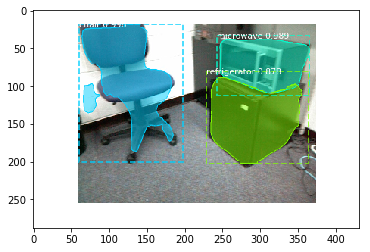

In [29]:
idx = 5000
result = node.forward(rgb_image_list[idx])
result_vis = node._visualize(result, rgb_image_list[idx])
import matplotlib.pyplot as plt
plt.plot()
plt.imshow(result_vis)

In [64]:
print(result.keys())
print(result['scores'])
print(result['class_ids'])

['rois', 'class_ids', 'masks', 'scores']
[0.9983436 0.9829721 0.8110065]
[57 69 70]


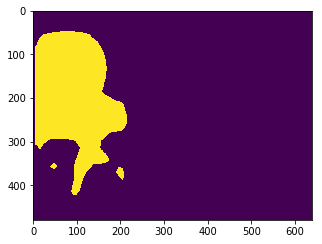

In [13]:
show_images([result['masks'][:,:,0]])

# 4 semantic-geometry refinement

In [16]:
# given normal map and depth map, output (1+cos(theta))/2
def normal_confidence(normal_map, depth_image, depth_map):
    cos_angle_map = -1*np.ones_like(depth_image)
    valid_norms = ~np.isnan(normal_map[:,:,0])
    inner_product = np.sum(np.multiply(normal_map[valid_norms],depth_map[valid_norms]), axis=-1)
    inner_product_normalized = inner_product/(np.linalg.norm(normal_map[valid_norms],axis=-1)*np.linalg.norm(depth_map[valid_norms],axis=-1))
    cos_angle_map[valid_norms] = -inner_product_normalized # reverse because the normals points at camera
    cos_angle_map_normalized = (cos_angle_map+1)/2
    return cos_angle_map_normalized

# output inverse depth values(meter^-1)
def depth_confidence(depth_image, thresholds = [0.1, 10]):
    depth_confidence_map = np.zeros_like(depth_image)
    valid_depth = np.logical_and(depth_image>0.1, depth_image<10)
    depth_confidence_map[valid_depth] = 1/depth_image[valid_depth]
    return depth_confidence_map

def confidence_calculation(depth_img_scaled, depth_map, normal_map):
    cos_angle_map = normal_confidence(normal_map, depth_img_scaled, depth_map)
    depth_confidence_map = depth_confidence(depth_img_scaled)
    return cos_angle_map, depth_confidence_map

# calculate geometry confidence given normal_confidence and depth_confidence
def geometry_confidence_calculation(cos_angle_map, depth_confidence_map):
    geometry_confidence_map = np.zeros_like(cos_angle_map)
    valid = np.logical_and((cos_angle_map>1e-3),depth_confidence_map>1e-3)
    geometry_confidence_map[valid] =  cos_angle_map[valid]+1.0*depth_confidence_map[valid]
    return geometry_confidence_map

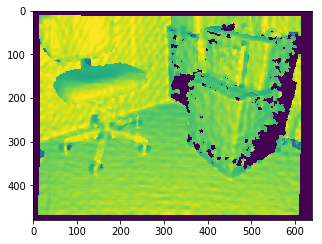

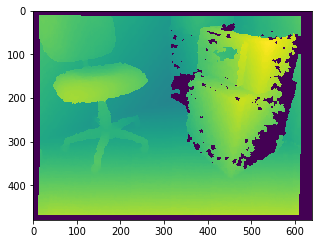

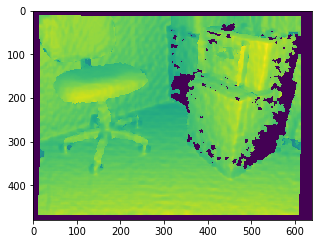

In [30]:
cos_normal_angle, depth_confidence_map = confidence_calculation(depth_img_scaled,depth_map,normal_map)
geometry_confidence_map = geometry_confidence_calculation(cos_normal_angle, depth_confidence_map)
# cos_normal_angle_show = cos_normal_angle.copy()
# cos_normal_angle_show += np.min(cos_normal_angle)
# cos_normal_angle_show *= (255.0/np.max(cos_normal_angle_show)).astype(np.uint8)
# cos_normal_angle_show2 = cos_normal_angle.copy()
# cos_normal_angle_show2[cos_normal_angle<0] += 0
# cos_normal_angle_show2 *= (255.0/np.max(cos_normal_angle_show2)).astype(np.uint8)

show_images([cos_normal_angle])
show_images([depth_confidence_map])
# show_images([cos_normal_angle_show<=1e-3])
# show_images([depth_img])
# show_images([rgb_img])
show_images([geometry_confidence_map])

In [19]:
geometry_confidence_map = np.zeros_like(cos_normal_angle)
print(geometry_confidence_map.shape)
valid = np.logical_and((cos_normal_angle>1e-3),depth_confidence_map>1e-3)
print(valid.shape)
geometry_confidence_map[valid] =  cos_normal_angle[valid]+1.0*depth_confidence_map[valid]
print(geometry_confidence_map.shape)

(480, 640)
(480, 640)
(480, 640)


In [20]:
class Segment:
    def __init__(self, depth_map, rgb_image, pose, mask):

        self.mask = mask
        self.rgb_image = rgb_image.astype(np.uint8)
        self.depth_map = depth_map.astype(float)
        self.pose = pose.astype(float)

        self.instance_label=0
        self.class_label=0
        self.label_confidence=1
        self.geometry_confidence = None

    def labelSegments(self, semantic_results, overlap_th = 0.8):
        classes = semantic_results['class_ids']
        instances_masks = semantic_results['masks']
        scores = semantic_results['scores']

        max_overlap_times_score = 0.0
        # search instances for the one with max overlap
        for instance_i in range(len(classes)):
            instance_mask = instances_masks[:,:,instance_i]
            instance_score = scores[instance_i]

            overlap = np.sum(np.logical_and(self.mask, instance_mask))
            overlap_normalized = overlap*1.0/np.sum(self.mask!=0)
            overlap_times_score = overlap_normalized*instance_score

            if(overlap_times_score>max_overlap_times_score and overlap_normalized>overlap_th):
                max_overlap_times_score = overlap_times_score
                self.instance_label = instance_i + 1
                self.class_label = classes[instance_i]

        if(self.instance_label!=0):
            self.label_confidence = max_overlap_times_score

    def generatePoints(self, geometry_confidence):
        
        self.geometry_confidence = geometry_confidence[self.mask!=0].astype(float)
        self.points = self.depth_map[self.mask!=0].astype(float)
        self.colors = self.rgb_image[self.mask!=0].astype(np.uint8)
        

        
        

In [31]:
segment_masks =  segmentor.get_segmentMasks()
segments_list = []
for segment_i in range(segment_masks.shape[0]):
    seg = Segment(depth_map,rgb_img,pose,segment_masks[segment_i,:,:])
    seg.labelSegments(result)
    seg.generatePoints(geometry_confidence_map)
    segments_list.append(seg)

chair_geometry_confidence_map = np.zeros_like(geometry_confidence_map)
label_confidence_map = np.zeros_like(geometry_confidence_map)
for segment in segments_list:
    if segment.class_label != 0:
        chair_geometry_confidence_map[segment.mask!=0] = segment.geometry_confidence
        label_confidence_map[segment.mask!=0] = segment.label_confidence

all_segs_geometry_confidence_map = np.zeros_like(geometry_confidence_map)
for segment in segments_list:
    all_segs_geometry_confidence_map[segment.mask!=0] = segment.geometry_confidence


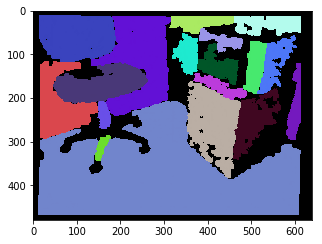

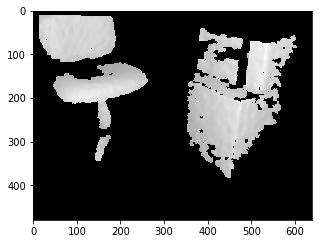

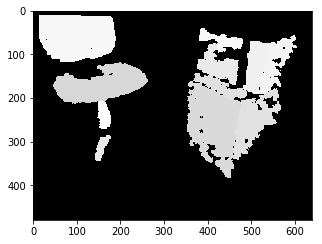

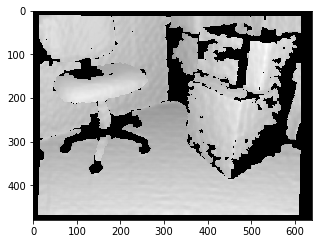

In [32]:
chair_geometry_confidence_map_toshow = chair_geometry_confidence_map.copy()
chair_geometry_confidence_map_toshow += np.min(chair_geometry_confidence_map_toshow[chair_geometry_confidence_map_toshow!=0])
chair_geometry_confidence_map_toshow *= 255.0/(np.max(chair_geometry_confidence_map_toshow))
label_confidence_map_toshow = label_confidence_map.copy()
label_confidence_map_toshow *= 255.0/(np.max(label_confidence_map_toshow))
show_images([label_map])
show_images([chair_geometry_confidence_map_toshow],cmap='gray')
show_images([label_confidence_map_toshow],cmap='gray')
show_images([all_segs_geometry_confidence_map],cmap='gray')

# 5. feed into GSM

In [ ]:
# import python module of depth_segmentation
lib_path = "/home/yang/thesis_test/toolbox/voxbloxpp_ws/devel/lib"
sys.path.append(lib_path)
import gsm_py

: 

: 